# RECOVAR visualization and analysis (copied from cryoDRGN's)

This jupyter notebook provides a template for analyzing results, including:
* latent space visualization with PCA/UMAP
* clustering
* interactive visualization of the latent space, imaging, and pose parameters
* interactive selection of particle images from the latent space
* interactive generation of volumes from the latent space

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.



In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
# from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Load results

In [3]:
# Specify the result dir
WORKDIR = '..' 
recovar_result_dir = '/scratch/gpfs/mg6942/cryodrgn_empiar/empiar10076/inputs/recovar_input_3/'
recovar_result_dir = '/home/mg6942/mytigress/uniform/recovar_from_halfmapstest/'

In [4]:
# Load z
from recovar import output
from recovar import dataset
results = output.load_results_new(recovar_result_dir)
cryos = dataset.load_dataset_from_args(results['input_args'], lazy = True)
z_dim_used = list(results['zs'].keys())[-1]
print("available zdim:", list(results['zs'].keys()), "using:", z_dim_used)
z = results['zs'][z_dim_used]

(INFO) (dataset.py) (17-Oct-23 19:00:47) Loading halfset from file
(INFO) (ctf.py) (17-Oct-23 19:00:47) Image size (pix)  : 128
(INFO) (ctf.py) (17-Oct-23 19:00:47) A/pix             : 6.0
(INFO) (ctf.py) (17-Oct-23 19:00:47) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (17-Oct-23 19:00:47) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (17-Oct-23 19:00:47) Dfang (deg)       : 0.0
(INFO) (ctf.py) (17-Oct-23 19:00:47) voltage (kV)      : 300.0
(INFO) (ctf.py) (17-Oct-23 19:00:47) cs (mm)           : 2.0
(INFO) (ctf.py) (17-Oct-23 19:00:47) w                 : 0.10000000149011612
(INFO) (ctf.py) (17-Oct-23 19:00:47) Phase shift (deg) : 0.0
(INFO) (ctf.py) (17-Oct-23 19:00:48) Image size (pix)  : 128
(INFO) (ctf.py) (17-Oct-23 19:00:48) A/pix             : 6.0
(INFO) (ctf.py) (17-Oct-23 19:00:48) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (17-Oct-23 19:00:48) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (17-Oct-23 19:00:48) Dfang (deg)       : 0.0
(INFO) (ctf.py) (

In [5]:
# Load UMAP
umap = utils.load_pkl(f'{recovar_result_dir}output/umap_embedding.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

/home/mg6942/miniconda3/envs/recovar/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



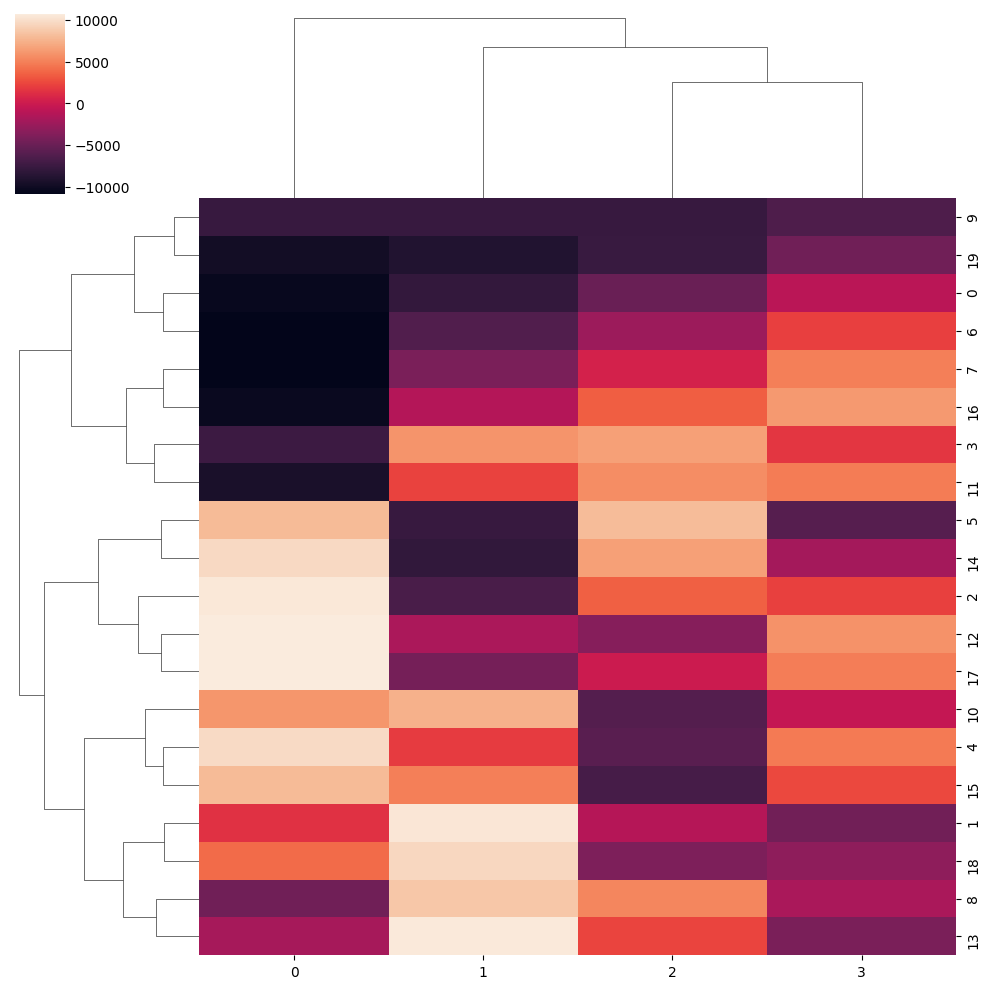

In [6]:
# Load kmeans
# K = 40
# kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
# kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
# Or re-run kmeans with the desired number of classes
kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# # Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Load dataset

In [7]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])

(INFO) (ctf.py) (17-Oct-23 19:00:49) Image size (pix)  : 27937
(INFO) (ctf.py) (17-Oct-23 19:00:49) A/pix             : 27937.390625
(INFO) (ctf.py) (17-Oct-23 19:00:49) DefocusU (A)      : 0.0
(INFO) (ctf.py) (17-Oct-23 19:00:49) DefocusV (A)      : 300.0
(INFO) (ctf.py) (17-Oct-23 19:00:49) Dfang (deg)       : 2.0
(INFO) (ctf.py) (17-Oct-23 19:00:49) voltage (kV)      : 0.10000000149011612
(INFO) (ctf.py) (17-Oct-23 19:00:49) cs (mm)           : 0.0
(INFO) (ctf.py) (17-Oct-23 19:00:49) w                 : 0.0
(INFO) (ctf.py) (17-Oct-23 19:00:49) Phase shift (deg) : 1.0


### Learning curve

### PCA

In [8]:
pc, pca = analysis.run_pca(z)

(INFO) (analysis.py) (17-Oct-23 19:00:49) Explained variance ratio:
(INFO) (analysis.py) (17-Oct-23 19:00:49) [0.42556924 0.29128855 0.17010851 0.11303367]


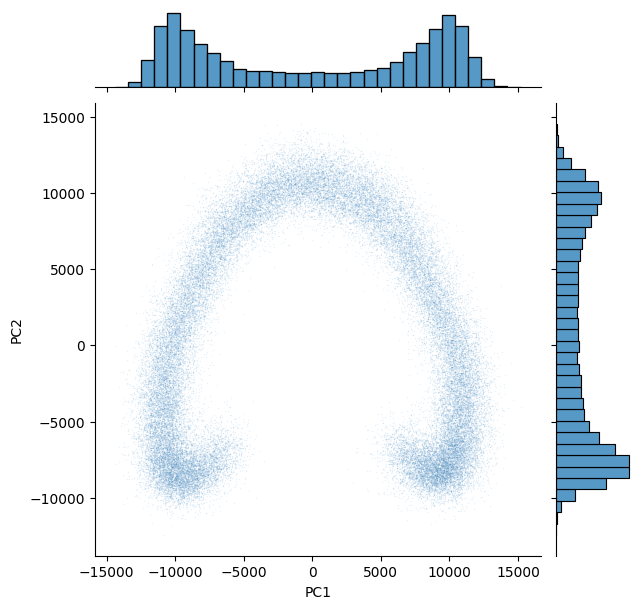

In [9]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

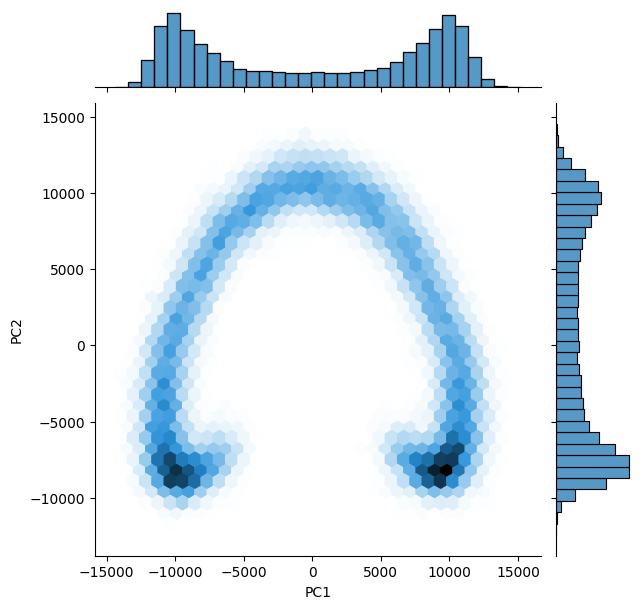

In [10]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

In [11]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

Text(0, 0.5, 'explained variance')

### View pose distribution

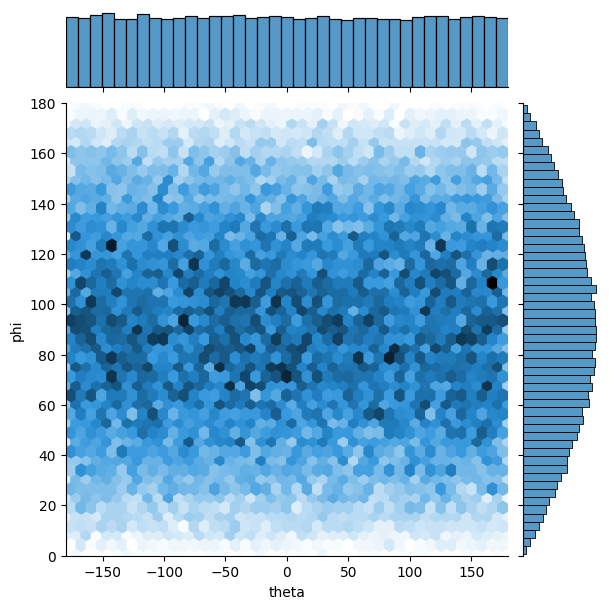

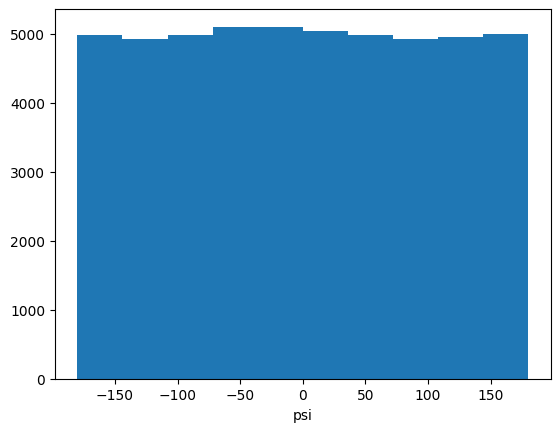

In [12]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

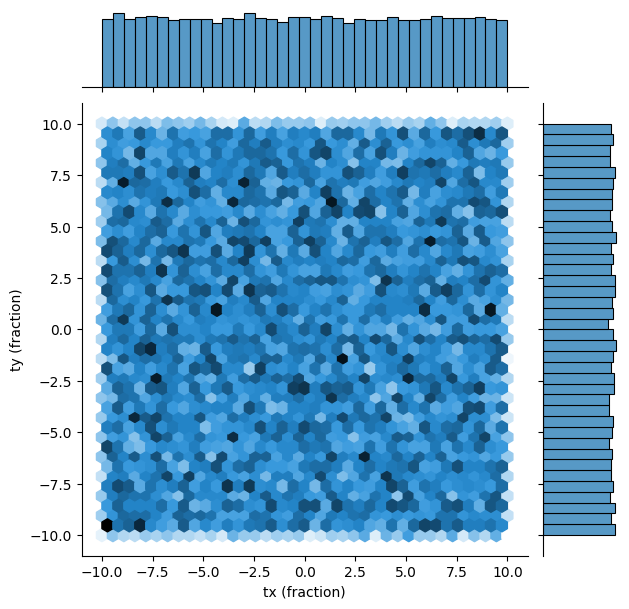

In [13]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### View UMAP

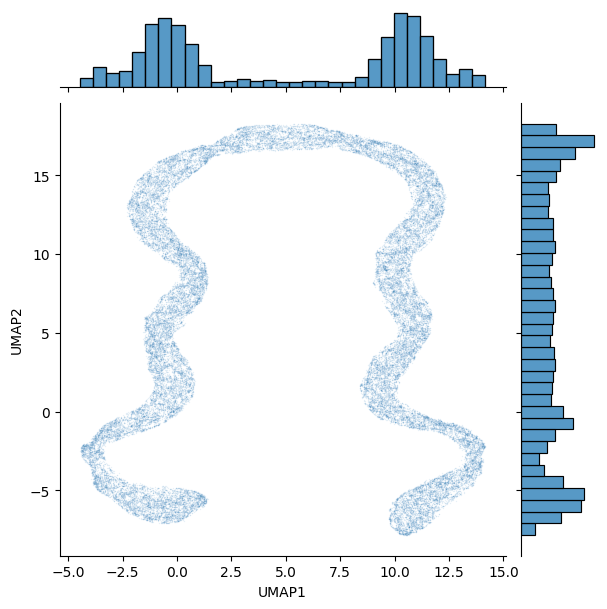

In [14]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

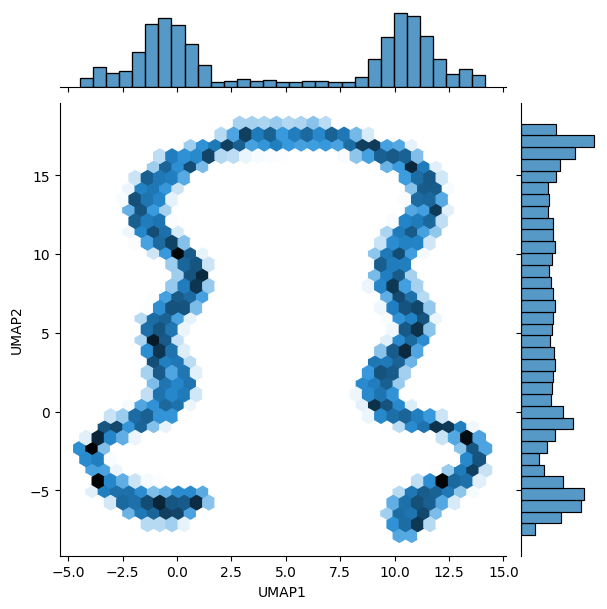

In [15]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

### View K-means clusters

Text(0, 0.5, 'PC2')

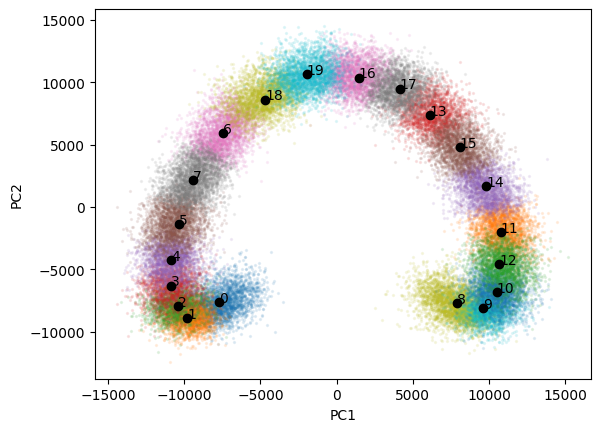

In [16]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

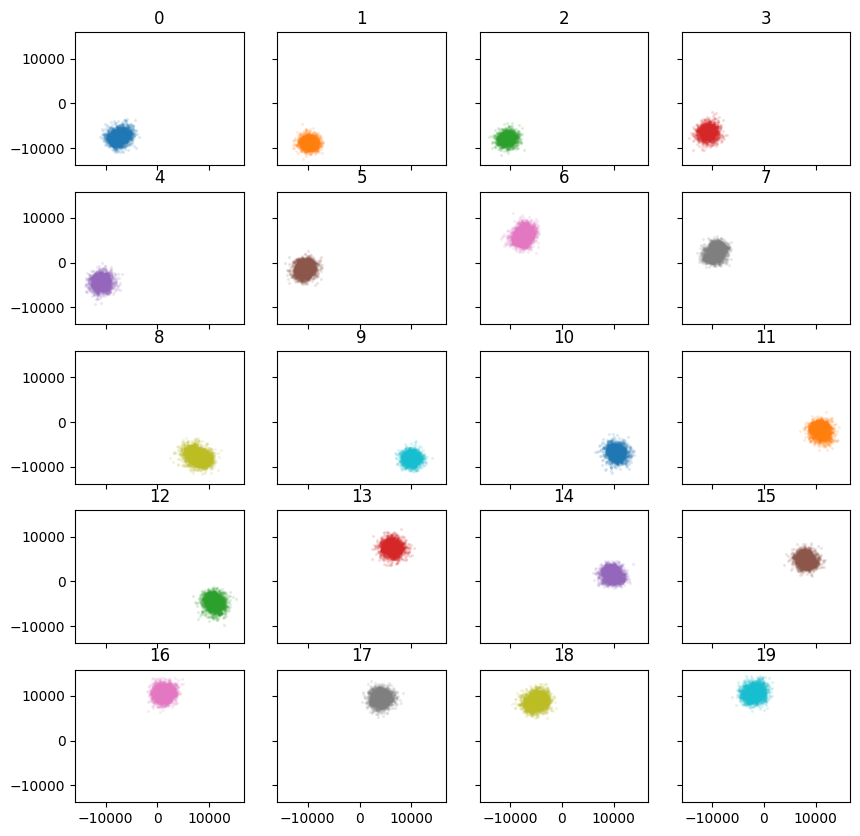

In [17]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

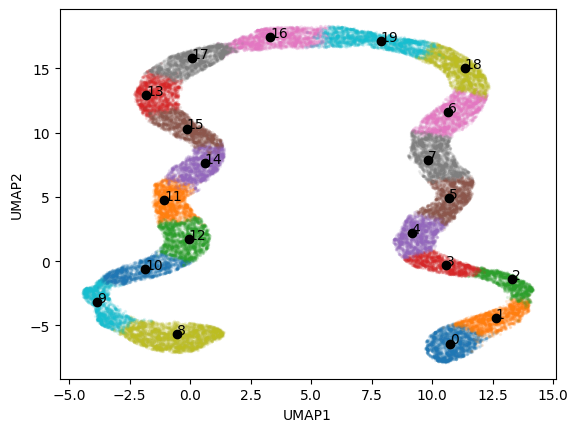

In [18]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

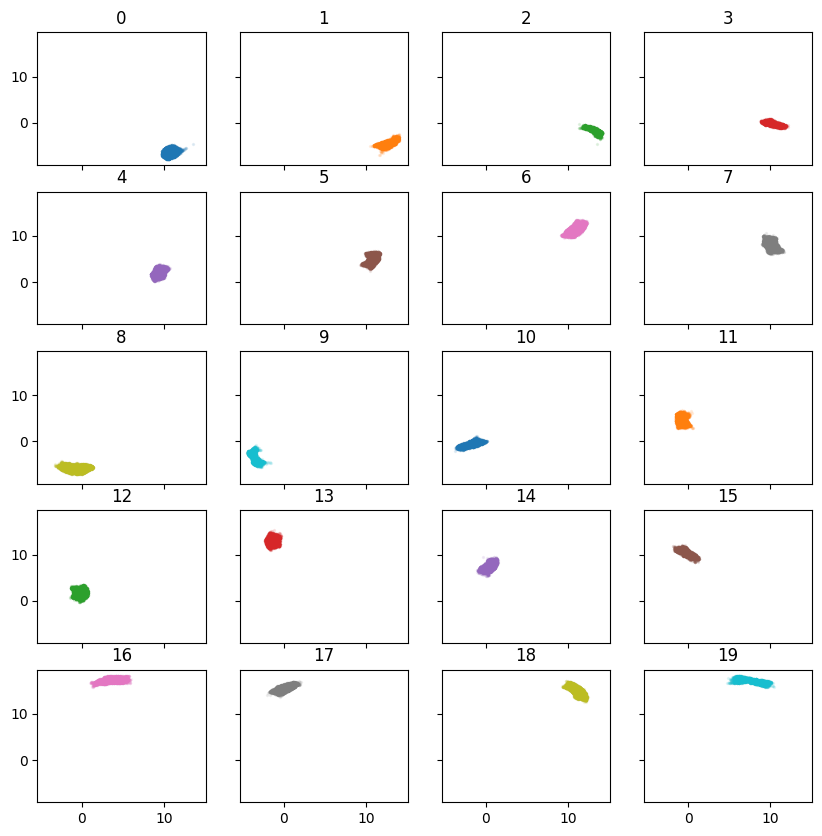

In [19]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

### Load into pandas dataframe

In [20]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8])
df.head()

UMAP1      UMAP2           PC1           PC2          PC3          PC4  \
0  10.068542   3.263242 -10071.634766  -4113.812012  3446.099365 -2959.340576   
1  11.224597  13.241982  -6641.215332   6901.431152  6816.341797  1306.999756   
2  -3.139068  -4.495332   9471.923828  -8669.291992  7357.490234  3921.436035   
3   3.362475  17.270130   2561.935791  10828.184570   350.807617  3210.336914   
4  -1.100325  -0.057528  11986.804688  -4723.676270  3171.359619 -2842.518311   

   labels       theta         phi         psi  ...        ty            z0  \
0       4 -118.795331   98.429599  177.996209  ...  3.036085 -10043.954102   
1       6 -101.753048  129.840670   39.004945  ... -4.227452  -6654.417480   
2       9  -51.982358   90.595178 -174.003444  ... -3.533598   9558.151367   
3      16   44.808382  114.535523  -32.372861  ... -6.052893   2482.965332   
4      10 -173.519756  104.088980  106.611879  ...  3.470774  12015.538086   

             z1           z2           z3  df1    df2  dfang  phase  index  
0  -4067.133301  3414.464844  3161.096436  0.0  300.0    2.0    1.0      0  
1   6892.383301  6914.272949 -1176.521484  0.0  300.0    2.0    1.0      1  
2  -8620.401367  7378.562988 -3521.587158  0.0  300.0    2.0    1.0      2  
3  10859.811523   455.996796 -3321.667236  0.0  300.0    2.0    1.0      3  
4  -4543.845215  2994.141357  3057.704102  0.0  300.0    2.0    1.0      4  

[5 rows x 21 columns]

In [21]:
# Annotated points correspond to kmeans cluster centers
widget, fig = analysis.ipy_plot_interactive_annotate(df,centers_ind)
VBox((widget,fig))

# Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, use the next cell to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [22]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [23]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = np.array(sorted(set(np.arange(len(df))) - set(ind_selected)))

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    0     1     2 ... 49997 49998 49999]
Number of selected points:
50000
Number of unselected points:
0


### Visualize selected subset

Text(0, 0.5, 'PC2 (0.29)')

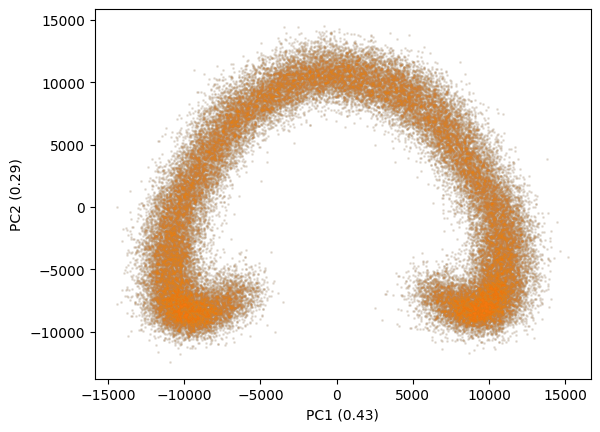

In [24]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

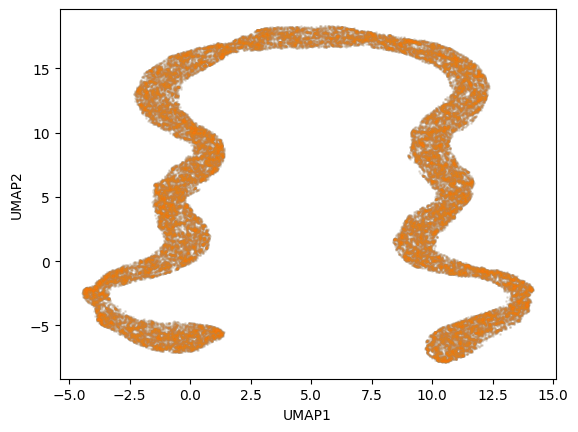

In [25]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [42]:
# Subset of dataframe
df_sub = df.loc[ind_selected]
df_sub_not = df.loc[ind_selected_not]

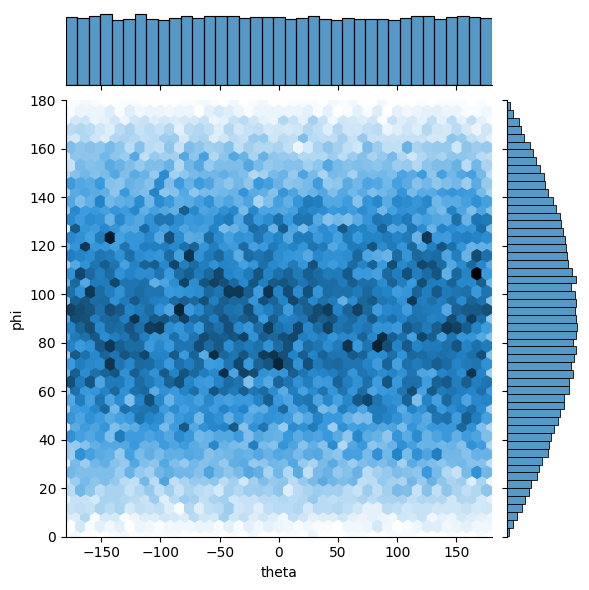

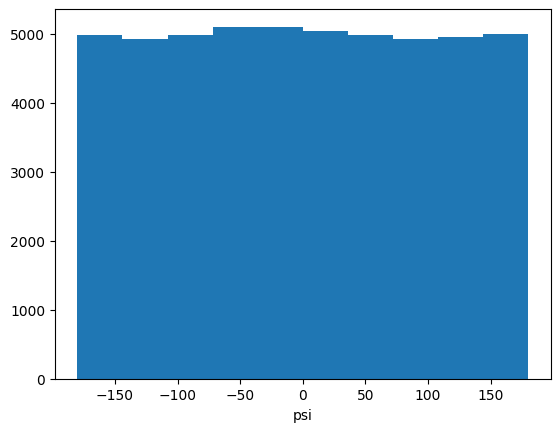

In [43]:
# View pose distribution
analysis.plot_euler(df_sub.theta, df_sub.phi, df_sub.psi)

In [44]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df_sub)
VBox((widget,fig,ind_table))

In [45]:
# import plotly
# import numpy as np
# X = np.random.randn(10,3)
# from recovar import plot_utils
# plot_utils.plotly_scatter([X])
# # import plotly.express as px
# # fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
# # fig.write_html('first_figure.html', auto_open=True)


### Save the index selection

The indices for the selected particles may be saved for use in downstream processing in cryoDRGN or with other tools. Within cryoDRGN, selections are saved as an index array in `.pkl` file format. Then, the selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images. 

Tools are provided in the `utils` subdirectory of the cryoDRGN repo to help convert the index selection to `.star` file format.

**NOTE:** If there are multiple rounds of index filtering performed on the same particle stack (i.e. your results come from a training run that already uses an --ind subselection), the index selection must be converted into the correct indices into the original dataset.

In [46]:
#SAVE_PATH = f'{WORKDIR}/ind_selected.pkl' # RENAME ME

## IMPORTANT: convert index selection to original particles indices if current results have already been filtered

#if ind_orig is not None:
#    ind_selected_orig = analysis.convert_original_indices(ind_selected, N_orig, ind_orig)
#    utils.save_pkl(ind_selected_orig, SAVE_PATH)

#else:
#    utils.save_pkl(ind_selected, SAVE_PATH)

# View particles

View images at selected points in latent space

In [47]:
particle_ind = ind_selected # or set to custom selection

In [48]:
# choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[ 5336 48670  1073  6045 26002 26180  2779  3481  8110]


In [49]:
particle_ind

array([    0,     1,     2, ..., 49997, 49998, 49999])

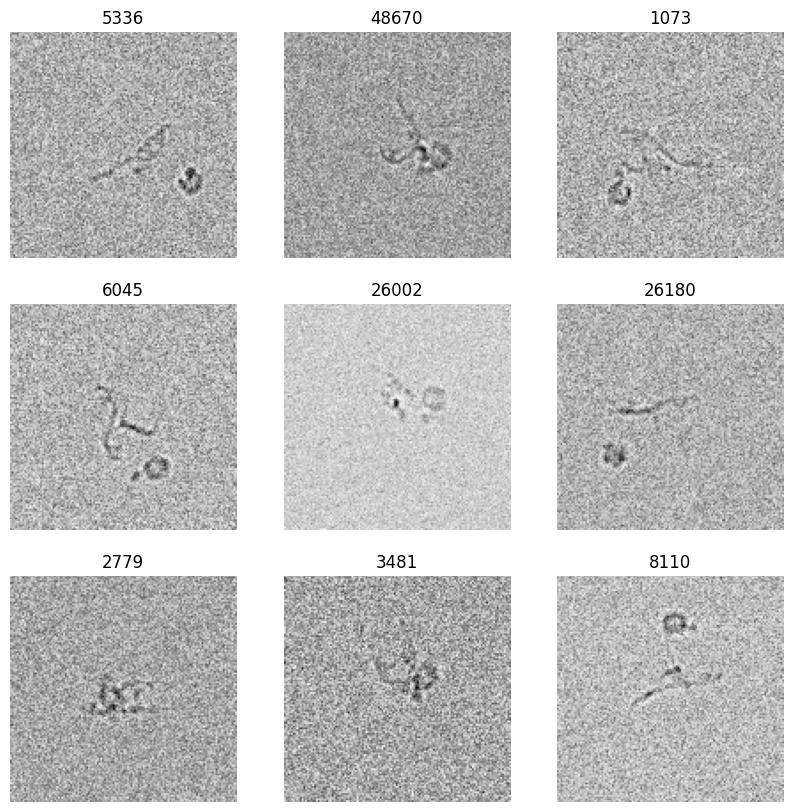

In [50]:
p = [cryos[0].get_image_real(ii % cryos[0].n_images) for ii in ind_subset9]
analysis.plot_projections(p, ind_subset9)
widget, fig = analysis.ipy_plot_interactive_annotate(df, ind_subset9, opacity=.1)
VBox((widget,fig))

# Generate volumes

Generate volumes at selected points in latent space

In [51]:
vol_ind = [] # ADD INDICES HERE
print(vol_ind)

[]


In [52]:
widget, fig = analysis.ipy_plot_interactive_annotate(df, vol_ind, opacity=.1)
VBox((widget,fig))

In [53]:
def get_outdir():
    '''Helper function to get a clean directory to save volumes'''
    for i in range(100000):
        outdir = f'reconstruct_{i:06d}'
        if os.path.exists(outdir): continue
        else: break
    return outdir

def generate_volumes(zvalues, outdir, **kwargs):
    '''Helper function to call cryodrgn eval_vol and generate new volumes'''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(f'{WORKDIR}/weights.{EPOCH}.pkl',
                         f'{WORKDIR}/config.pkl',
                         f'{outdir}/zfile.txt',
                         f'{outdir}', **kwargs)
    return FileLinks(f'{outdir}/')

In [54]:
# Get a unique output directory, or define your own
outdir = get_outdir()
print(os.path.abspath(outdir))

/home/mg6942/recovar/reconstruct_000000


In [55]:
# Modify any defaults for volume generation -- see `cryodrgn eval_vol -h` for details 
Apix = 1 # Set to volume pixel size
flip = False # Hand flip?
invert = False # Invert contrast?
downsample = None # Set to smaller box size if desired
cuda = None # specify cuda device

generate_volumes(z[vol_ind], outdir, Apix=cryos[0].voxel_size, flip=flip, downsample=downsample, cuda=cuda, invert=invert)

NameError: name 'EPOCH' is not defined